# 0. 프로젝트 설명

#### 이 프로젝트는 UCI Machine Learning Repository의 레드 와인과 화이트 와인 품질 데이터를 사용해 랜덤 포레스트(Random Forest) 모델로 와인 품질(0~10 점수)을 예측하는 것이 목표입니다. 인공 신경망의 경우 이전에  모델에 다른 데이터를 넣고 돌려본 경험이 있어서 새로운 모델로 도전해보고 싶어서 랜덤 포레스트(Random Forest) 모델을 선택했습니다. 주요 단계는 데이터 탐색 및 전처리(SMOTE로 불균형 데이터 보정), 알고리즘 매개변수 튜닝, 그리고 모델 성능 평가(정확도 65.6%)로 구성됩니다. 

# 1. 데이터 로드 및 초기 탐색

#### [Wine Quality - UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/186/wine+quality) 에서 다운 받은 레드 와인과 화이트 와인 데이터를 로드하고, 각 데이터셋에 와인 종류를 나타내는 새로운 열을 추가합니다.
#### 두 데이터를 하나의 데이터프레임으로 결합하고, type 열을 숫자로 인코딩하여 모델이 이를 처리할 수 있도록 합니다.

#### fixed acidity (고정된 산도):
와인의 고정된 산도는 발효 과정에서 변하지 않는 산 성분을 말합니다. 일반적으로 주석산, 구연산, 말산 등이 포함됩니다.

#### volatile acidity (휘발성 산도):
휘발성 산도는 주로 아세트산과 같은 휘발성 산이 포함되어 있으며, 와인의 발효 또는 저장 중에 발생할 수 있는 산도입니다.

#### citric Acid (구연산):
와인에서 발견되는 천연 산 중 하나입니다.

#### residual Sugar (잔류 당):
발효 후 와인에 남아 있는 당분의 양을 의미합니다.

#### chlorides (염화물):
와인에 포함된 소금 성분을 나타냅니다.

#### free sulfur dioxide (유리 아황산가스):
와인에 남아 있는 화학적 보존제의 일종으로, 미생물의 성장을 억제하고 산화를 방지합니다.

#### total sulfur dioxide (총 아황산가스):
유리 아황산가스와 결합된 아황산가스를 포함한 총량을 나타냅니다.

#### density (밀도):
와인의 밀도는 주로 알코올과 당분의 농도에 의해 결정되며, 이는 와인의 바디감과 질감을 나타내는 지표가 될 수 있습니다.

#### pH:
pH는 와인의 산도를 측정하는 척도로, 와인의 안정성과 맛에 영향을 미칩니다.

#### sulphates (황산염):
황산염은 와인의 항산화제로 사용되며, 발효를 촉진하고 와인의 맛을 개선하는 데 도움을 줄 수 있습니다.

#### alcohol (알코올):
알코올 함량은 발효 과정에서 당분이 알코올로 변환되어 생성됩니다. 알코올은 와인의 바디와 풍미에 영향을 미칩니다.

#### quality (품질):
와인의 품질은 감각적 데이터에 기반한 점수로, 일반적으로 향, 맛, 균형, 구조 등을 평가하여 0에서 10까지의 점수로 나타냅니다. 높은 점수는 더 높은 품질을 의미합니다.

#### 저는 이 중에서 quality를 target으로 지정하여 랜덤 포레스트 모델을 학습시킬 것 입니다.

In [1]:
# 필요한 라이브러리 임포트
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

In [2]:
# 데이터셋 로드
red_wine = pd.read_csv("winequality-red.csv", sep=';')
white_wine = pd.read_csv("winequality-white.csv", sep=';')

# 와인 종류를 특징으로 추가
red_wine['type'] = 'red'
white_wine['type'] = 'white'

# 데이터셋 결합
wine_data = pd.concat([red_wine, white_wine], axis=0)

# 'type' 열 인코딩
wine_data['type'] = wine_data['type'].map({'red': 0, 'white': 1})

# 데이터셋 확인
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


# 2. 데이터 전처리 및 분할

#### quality 열을 타겟 변수로 설정하고 나머지 열을 특징 변수로 설정합니다.
#### 데이터를 학습 세트와 테스트 세트로 분할하여 모델의 학습과 평가에 사용합니다.

In [3]:
# 데이터 전처리
X = wine_data.drop('quality', axis=1)  # 특징 변수
y = wine_data['quality']               # 타겟 변수

# 학습 세트와 테스트 세트로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
print(f'train samples: {len(X_train)}\ntest samples: {len(X_test)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 5197
test samples: 1300
target proportion: 5.8145


# 3. 오버샘플링을 통한 데이터 균형 조정

#### SMOTE를 사용하여 학습 데이터의 소수 클래스를 오버샘플링합니다.
#### 오버샘플링 전후의 클래스 분포를 출력하여 결과를 확인합니다.

In [5]:
# 각 클래스의 샘플 수 확인
print("클래스 분포:\n", y_train.value_counts())

# SMOTE를 사용한 오버샘플링
sampling_strategy = {
    6: 2300,
    5: 1800,
    7: 1500,
    4: 500,
    8: 500,
    3: 300,
    9: 100
}

smote = SMOTE(sampling_strategy=sampling_strategy, k_neighbors=3, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 오버샘플링 후 클래스 분포 확인
print("Resampled class distribution:\n", pd.Series(y_train_resampled).value_counts())

클래스 분포:
 quality
6    2239
5    1736
7     864
4     173
8     157
3      24
9       4
Name: count, dtype: int64
Resampled class distribution:
 quality
6    2300
5    1800
7    1500
4     500
8     500
3     300
9     100
Name: count, dtype: int64


# 4. 모델 학습 및 평가

#### 오버샘플링된 학습 데이터를 사용하여 모델을 학습합니다.

In [6]:
# Parameter lists for tuning
RANDOM_STATE = 42
min_samples_split_list = [2, 10, 30, 50, 100, 200, 300, 700]  
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10, 50, 100, 500]

## 4-1. 내부 노드를 분할하는 데 필요한 최소 샘플 수를 조정하여 모델 학습

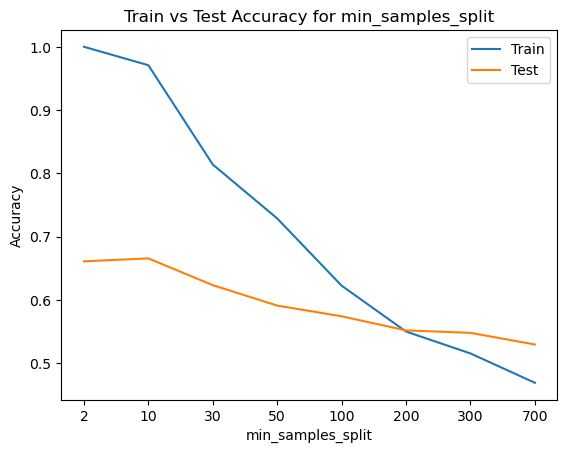

In [7]:
# Tuning `min_samples_split`
accuracy_list_train = []
accuracy_list_test = []

for min_samples_split in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split=min_samples_split, random_state=RANDOM_STATE)
    model.fit(X_train_resampled, y_train_resampled)
    predictions_train = model.predict(X_train_resampled)
    predictions_test = model.predict(X_test)
    accuracy_train = accuracy_score(y_train_resampled, predictions_train)
    accuracy_test = accuracy_score(y_test, predictions_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train vs Test Accuracy for min_samples_split')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(accuracy_list_train, label='Train')
plt.plot(accuracy_list_test, label='Test')
plt.legend()
plt.show()

#### 최소 샘플 수가 10개일 때 test set의 정확도가 가장 높은것을 확인할 수 있습니다.

## 4-2. 트리의 최대 깊이를 조정하여 모델 학습

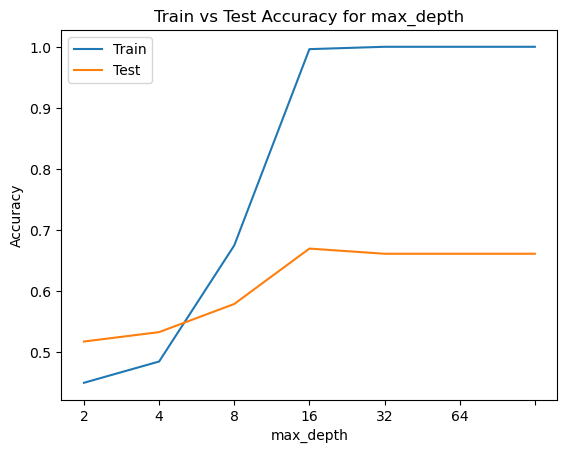

In [8]:
# Tuning `max_depth`
accuracy_list_train = []
accuracy_list_test = []

for max_depth in max_depth_list:
    model = RandomForestClassifier(max_depth=max_depth, random_state=RANDOM_STATE)
    model.fit(X_train_resampled, y_train_resampled)
    predictions_train = model.predict(X_train_resampled)
    predictions_test = model.predict(X_test)
    accuracy_train = accuracy_score(y_train_resampled, predictions_train)
    accuracy_test = accuracy_score(y_test, predictions_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train vs Test Accuracy for max_depth')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(accuracy_list_train, label='Train')
plt.plot(accuracy_list_test, label='Test')
plt.legend()
plt.show()

#### 트리의 최대 깊이가 16일 때 test set의 정확도가 가장 높은것을 확인할 수 있습니다.

## 4-3. 의사 결정 트리 수를 조정하여 모델 학습

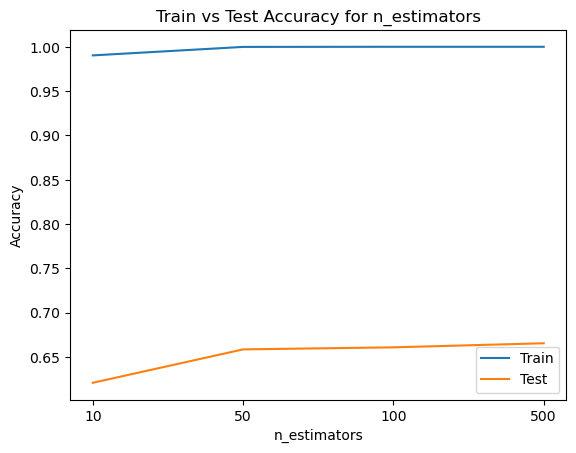

In [9]:
# Tuning `n_estimators`
accuracy_list_train = []
accuracy_list_test = []

for n_estimators in n_estimators_list:
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=RANDOM_STATE)
    model.fit(X_train_resampled, y_train_resampled)
    predictions_train = model.predict(X_train_resampled)
    predictions_test = model.predict(X_test)
    accuracy_train = accuracy_score(y_train_resampled, predictions_train)
    accuracy_test = accuracy_score(y_test, predictions_test)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_test.append(accuracy_test)

plt.title('Train vs Test Accuracy for n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.xticks(ticks=range(len(n_estimators_list)), labels=n_estimators_list)
plt.plot(accuracy_list_train, label='Train')
plt.plot(accuracy_list_test, label='Test')
plt.legend()
plt.show()

#### 의사 결정 트리의 수가 50개 이상 넘어가면 test set의 정확도에 큰 변화가 없는것을 확인할 수 있습니다.

In [12]:
# Final Random Forest Model with selected parameters
random_forest_model = RandomForestClassifier(
    min_samples_split=10,
    max_depth=16,
    n_estimators=50,
    random_state=RANDOM_STATE
)
random_forest_model.fit(X_train_resampled, y_train_resampled)

print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train_resampled), y_train_resampled):.4f}")
print(f"Metrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_test), y_test):.4f}")

Metrics train:
	Accuracy score: 0.9479
Metrics test:
	Accuracy score: 0.6562


#### test set의 정확도는 약 65%가 나왔습니다.

# 5. 특징 중요도 시각화

#### 학습된 랜덤 포레스트 모델의 특징 중요도를 추출하고, 이를 시각화하여 모델이 어떤 특징에 주로 의존하는지를 확인합니다.
#### seaborn의 barplot을 사용하여 각 특징의 중요도를 시각적으로 표현합니다.

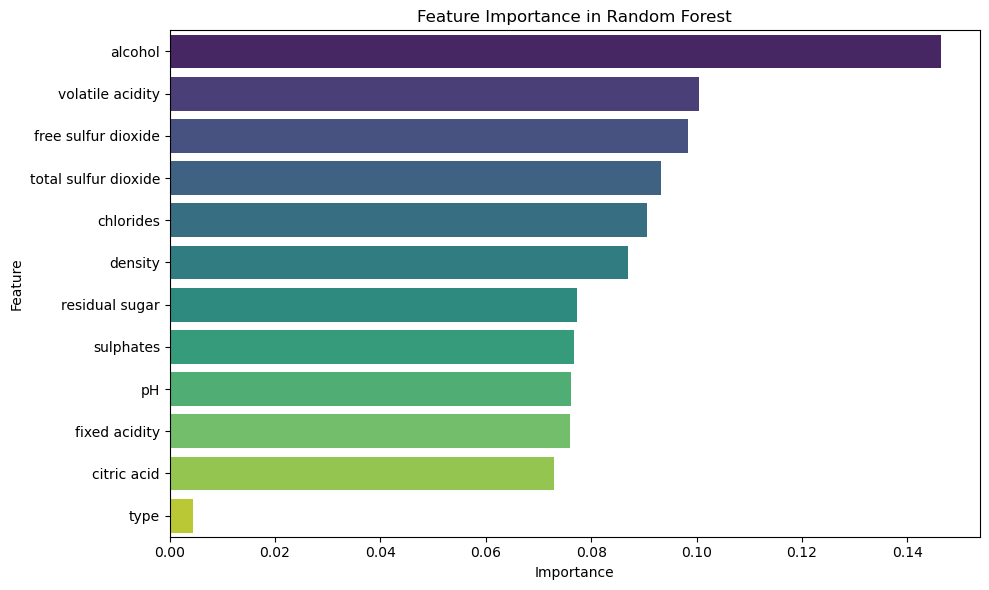

In [13]:
# 특징 중요도 시각화
importances = random_forest_model.feature_importances_
feature_names = X.columns

# 시각화를 위한 데이터프레임 생성
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# 특징 중요도 플롯
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance in Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 6. Chat GPT 활용

#### 저는 Chat GPT에게 클래스의 불균형(quality 6의 데이터 수:2239, quality 9의 데이터 수:4)을 해결하기 위한 방법을 물어봤습니다. 저는 Chat GPT가 추천해준 내용중에 오버샘플링을 사용했습니다. 이후 더 높은 정확도를 얻기 위해 샘플 수를 조정하는 방법을 물어봤습니다.
# [gpt 링크](https://chatgpt.com/share/6757b735-13fc-8003-90ad-71a6757a22f8)